In [3]:
# VERSION OF PYTHON USED IS 3.12.8

# Imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import inspect
import typing
from collections import Counter
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, confusion_matrix


# Data Parsing & Preprocessing

In [5]:
df = pd.read_csv('iris.txt', header=None, sep=' ')
df.columns = ['1','2','3','4', 'species']

# remove columns 1 and 4
df = df.drop(['1', '4'], axis=1)

# remove rows with species 'Iris-setosa'
df = df[df['species'] != 'Iris-setosa']

df

,2,3,species
50,3.2,4.7,Iris-versicolor
51,3.2,4.5,Iris-versicolor
52,3.1,4.9,Iris-versicolor
53,2.3,4.0,Iris-versicolor
54,2.8,4.6,Iris-versicolor
...,...,...,...
145,3.0,5.2,Iris-virginica
146,2.5,5.0,Iris-virginica
147,3.0,5.2,Iris-virginica
148,3.4,5.4,Iris-virginica


# Data Visualization

(0.0, 8.0)

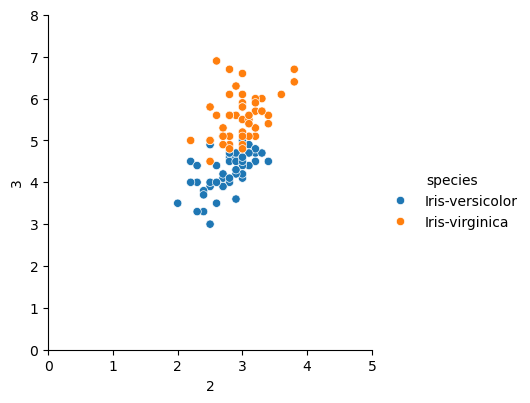

In [6]:
# plot the data

sns.pairplot(df, hue='species', x_vars='2', y_vars='3', height=4, aspect=1, kind='scatter')

# Setting axes starting at 0
plt.xlim(0, 5)
plt.ylim(0, 8)

# Project Structure

### Knn Model:
- creating a model
- .set(hyp_params)
- .train(training_data) - this only saves a copy of the training data - nothing more
- .predict(data) - check the majority label of the neighbors of each sample

### Average Function:
- signeture: 

def return_avg(model, df, train_test_precentage, model_parameters, num_of_runs) -> df_of_errors_per_parameters

# Knn Model Definition

In [18]:
import numpy as np
from collections import Counter
import inspect
import typing

class KNN:
    def __init__(self):
        self.k = 3  # Default number of neighbors
        self.distance_metric = 'euclidean'  # Default distance metric
        self.data = None
        self.labels = None # the labels could be non-numeric

    def set(self, **kwargs):
        """
        Set the hyperparameters of the KNN model.

        Parameters:
        - k: int, Number of neighbors to consider.
        - distance_metric: str or callable, Distance metric to use ('euclidean', 'manhattan', or a user-defined function).
        """

        # ensure all keys are valid
        valid_keys = {'k', 'distance_metric'}
        for key in kwargs:
            if key not in valid_keys:
                raise ValueError(f"Invalid argument: {key}. Valid arguments are {valid_keys}.")
            
        if 'k' in kwargs:
            if not isinstance(kwargs['k'], int) or kwargs['k'] <= 0:
                raise ValueError("k must be a positive integer.")
            self.k = kwargs['k']

        if 'distance_metric' in kwargs:
            distance_metric = kwargs['distance_metric']
            if isinstance(distance_metric, str):
                if distance_metric not in ['euclidean', 'manhattan', 'maximum norm']:
                    raise ValueError("distance_metric must be 'euclidean', 'manhattan', 'maximum norm' or a callable function.")
            elif callable(distance_metric):
                # Validate the function signature
                sig = inspect.signature(distance_metric)
                params = sig.parameters

                # 1. Check the number of parameters
                if len(params) != 2:
                    raise ValueError("distance_metric callable must accept exactly two parameters.")

                # 2. Check type hints for parameters, if available
                hints = typing.get_type_hints(distance_metric)
                if 'return' in hints:
                    return_type = hints['return']
                    if not np.issubdtype(np.dtype(return_type).type, np.floating):
                        raise ValueError("distance_metric function must have a return type that is float-like.")

                param_types = [hints.get(param, None) for param in params]
                if None not in param_types and param_types[0] != param_types[1]:
                    raise ValueError("The two parameters of distance_metric must have identical types if type hints are provided.")
            else:
                raise ValueError("distance_metric must be 'euclidean', 'manhattan', or a callable function.")

            self.distance_metric = distance_metric

    def train(self, data, labels):
        """
        Provide the training data to the KNN model.

        Parameters:
        - data: Any array-like structure, Training data points.
        - labels: Any array-like structure, Corresponding labels for the training data.
        """
        try:
            data = np.array(data)
            labels = np.array(labels)
            # # DEBUG:
            # return labels
            # # END DEBUG
        except Exception as e:
            raise ValueError("data and labels must be convertible to numpy arrays.") from e

        if len(data) != len(labels):
            raise ValueError("data and labels must have the same length.")

        self.data = data
        self.labels = labels

    def _calculate_distance(self, point1, point2):
        if isinstance(self.distance_metric, str):
            if self.distance_metric == 'euclidean':
                return np.sqrt(np.sum((point1 - point2) ** 2))
            elif self.distance_metric == 'manhattan':
                return np.sum(np.abs(point1 - point2))
            elif self.distance_metric == 'maximum norm':
                return np.max(np.abs(point1 - point2))
        elif callable(self.distance_metric):
            return self.distance_metric(point1, point2)
            
    def predict(self, point):
        """
        Predict the label for a single data point.

        Parameters:
        - point: Any array-like structure, The data point to predict.

        Returns:
        - The predicted label.
        """
        if self.data is None or self.labels is None:
            raise ValueError("Model do not have any data or/and labels. it could be that it has not been trained. Call train().")

        try:
            point = np.array(point)
        except Exception as e:
            raise ValueError("point must be convertible to a numpy array.") from e

        distances = [self._calculate_distance(point, data_point) for data_point in self.data]
        nearest_indices = np.argsort(distances)[:self.k]
        nearest_labels = [self.labels[i] for i in nearest_indices] # this contains the labels, they could be non-numeric.

        most_common_label = Counter(nearest_labels).most_common(1)[0][0]
        return most_common_label
    
    def predict_batch(self, X):
        return [self.predict(point) for point in X]
    

# Example Knn Usage:

In [19]:
# Initialize the KNN model
knn = KNN()

# Set hyperparameters with a custom distance metric
def custom_distance(p1, p2):
    return np.sum((p1 - p2) ** 2)  # Example custom metric

knn.set(k=5, distance_metric=custom_distance)

# Randomly sample half the rows for the training set
train_df = df.sample(frac=0.5, random_state=42)

# Use the remaining rows for the test set
test_df = df.drop(train_df.index)

# Provide training data
X_train = train_df[['2','3']]
y_train = train_df['species']

X_test = test_df[['2','3']]
y_test = test_df['species']

knn.train(X_train, y_train)
# Predict for a new data point
prediction = knn.predict((2.5,7))
print(f"Predicted label: {prediction}")


Predicted label: Iris-virginica


# Average Function Definition

In [20]:
################## IMPLEMENTATION2 ##################
# steps of the function:
    # for i in num_of_runs 
        # split the train and test with seed=i 
        # train the model with train data
        # for each of the combinations in model_parameters 
            # set the parameters of the model 
            # train_sum[parameters] += train_accuracy ## same for test (here train_sum is a dict whose values are the sum)
    # train_avg_acc = train_sum / num_of_runs ## same for test  (here train_avg_acc should be a dict)
    # save the train/test_avg_acc to a "result" df in the corressponding column
    # save train_avg_acc - test_avg_acc to the "result" df in the corressponding column
    # return the "result" df.

In [21]:
import pandas as pd
import numpy as np
import random
from itertools import product
from typing import List, Dict

def return_avg(
    model: KNN, 
    X: np.ndarray,
    y: np.ndarray, 
    train_test_precentage: float, 
    model_parameters: Dict[str, List], 
    num_of_runs: int
) -> pd.DataFrame:
    """
    Repeatedly trains and tests a KNN model on different parameter combinations 
    and returns average accuracies (train and test) along with their differences.

    Steps:
    1. For i in [0..num_of_runs-1]:
        a. Shuffle/split the train and test sets with seed = i.
        b. For each combination of parameters in model_parameters:
           - Set the KNN model parameters.
           - Train the model on the train split.
           - Calculate train accuracy and test accuracy.
           - Accumulate these accuracies in a sum dictionary.
    2. Compute average (train and test) accuracy by dividing sums by num_of_runs.
    3. Save the averaged results to a 'result' DataFrame with train_acc, test_acc,
       and (train_acc - test_acc).
    4. Return this 'result' DataFrame.

    Parameters
    ----------
    model : KNN
        An instance of a KNN class with .set()/.train()/.predict() methods.
    X : np.ndarray
        Feature matrix (shape [n_samples, n_features]).
    y : np.ndarray
        Label vector (shape [n_samples]).
    train_test_precentage : float
        Fraction of data to be used for training, e.g. 0.8 for 80% training data.
    model_parameters : Dict[str, List]
        A dictionary where each key is a hyperparameter name and the value is a list of
        possible values for that hyperparameter.
        Example: {"k": [1,3,5], "distance_metric": ["euclidean", "manhattan"]}.
    num_of_runs : int
        Number of times to shuffle and rerun the training/testing process.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns describing each combination of parameters plus:
        - 'train_acc': averaged train accuracy,
        - 'test_acc': averaged test accuracy,
        - 'diff': (train_acc - test_acc).
    """

    # Ensure X and y have the same length
    if len(X) != len(y):
        raise ValueError("X and y must have the same length.")

    n_samples = len(X)
    train_size = int(train_test_precentage * n_samples)

    # Generate all combinations of hyperparameters
    param_keys = list(model_parameters.keys())
    param_combos = list(product(*model_parameters.values()))

    # Dictionary to accumulate sums: param_sums[combo] = [train_acc_sum, test_acc_sum]
    param_sums = {combo: [0.0, 0.0] for combo in param_combos}

    def accuracy(model_knn: KNN, X_data: np.ndarray, y_data: np.ndarray) -> float:
      """Compute accuracy of model_knn on the dataset (X_data, y_data)."""
      predictions = model_knn.predict_batch(X_data)
      correct = sum(pred == true for pred, true in zip(predictions, y_data))
      return correct / len(X_data) if len(X_data) > 0 else 0.0

    # ---------------------------------------
    # Repeated runs
    # ---------------------------------------
    for seed in range(num_of_runs):
        # Shuffle the dataset with a specific seed each time
        random.seed(seed)
        indices = list(range(n_samples))
        random.shuffle(indices)

        # Split into train and test based on the shuffled indices
        train_indices = indices[:train_size]
        test_indices = indices[train_size:]

        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]

        # For each combination of parameters
        for combo in param_combos:
            combo_dict = dict(zip(param_keys, combo))

            # Set parameters on the KNN model
            model.set(**combo_dict)

            # Train the model
            model.train(X_train, y_train)

            # Compute train/test accuracy
            train_acc = accuracy(model, X_train, y_train)
            test_acc  = accuracy(model, X_test, y_test)

            # Accumulate
            param_sums[combo][0] += train_acc
            param_sums[combo][1] += test_acc

    # ---------------------------------------
    # Compute averages and build result DataFrame
    # ---------------------------------------
    results_data = []
    for combo in param_combos:
        avg_train = param_sums[combo][0] / num_of_runs
        avg_test  = param_sums[combo][1] / num_of_runs

        # row = [param_value_1, param_value_2, ..., train_acc, test_acc, diff]
        row = list(combo) + [avg_train, avg_test, avg_train - avg_test]
        results_data.append(row)

    # Columns: parameter names + ['train_acc', 'test_acc', 'diff']
    columns = param_keys + ["train_acc", "test_acc", "diff"]
    result_df = pd.DataFrame(results_data, columns=columns)

    return result_df


In [25]:
# compute average accuracy for the KNN model
avg_acc_df = return_avg(
    model=knn,
    X=df.drop('species', axis=1).to_numpy(),
    y=df['species'].to_numpy(),
    train_test_precentage=0.5,
    model_parameters={"k": [1, 3, 5, 7, 9], "distance_metric": ["euclidean", "manhattan", "maximum norm"]},
    num_of_runs=100
)

In [27]:
avg_acc_df

,k,distance_metric,train_acc,test_acc,diff
0,1,euclidean,0.9842,0.8776,0.1066
1,1,manhattan,0.9844,0.8708,0.1136
2,1,maximum norm,0.9842,0.8656,0.1186
3,3,euclidean,0.9434,0.9068,0.0366
4,3,manhattan,0.9416,0.9072,0.0344
5,3,maximum norm,0.9438,0.9092,0.0346
6,5,euclidean,0.9376,0.9180,0.0196
7,5,manhattan,0.9374,0.9168,0.0206
8,5,maximum norm,0.9362,0.9162,0.0200
9,7,euclidean,0.9350,0.9206,0.0144
